<a href="https://colab.research.google.com/github/fox-craft/Carbon-Storage-Potential/blob/main/Carbon_Storage_Potential_Colombia_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Carbon Storage Potential of  Silvopastotal Systems of Colombia analysis.

This an adaptation of Aynekulu, E.; Suber, M.; van Noordwijk, M.; Arango, J.; Roshetko, J.M.; Rosenstock, T.S. Carbon Storage Potential of Silvopastoral Systems of Colombia. Land 2020, 9, 309. https://doi.org/10.3390/land9090309

Step 1: Library imports

In [ ]:
!pip install geemap
!pip install earthengine-api
!pip install leafmap
!pip install contextily
!pip install matplotlib_scalebar
!pip install rasterio

import os
import ee
import geemap
from google.colab import drive
from pprint import pprint
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from rasterio.plot import show
import zipfile
import requests
import io

Read Ecofloristiic Zones Shapefiles.

*As Ecofloristic zones layer for this specific paper is not available in GEE catalod, you'll need to download and upload somewhere in your drive then load it here*

In [ ]:
# Authenticate and initializedea
 = "jometho-greppo@ee-stevejometho.iam.gserviceaccount.com"
key_file = "D:\FX\silvo-carbon\ee-7fb52a8cfe29.json"

credentials = ee.ServiceAccountCredentials(email=email, key_file=key_file)
ee.Initialize(credentials)
ee.Authenticate()
ee.Initialize(project='ee-stevejometho') #Almost 3 hours to figure this out. Specify project ID to prevent defaulting to cloud project you don't have access to
drive.mount('/content/drive')

Mounted at /content/drive


Since the Ecofloristic zones Shapefile (2015)0 is nolonger in the GEE Catalog, wI have uploaded it to my GDrive.

This step downloads the .zip from my drive and unzips it into the temp dir for processing natively.

In [ ]:

print('Making temp files dir')
!mkdir /tmp/files

print('Unzipping shapefile...')
!unzip "drive/My Drive/Colab Notebooks/carbon_analysis/ecofloristic_zones.zip" -d /tmp/files
!ls /tmp/files

print("Done unzipping")

Making temp files dir
Unzipping shapefile...
Archive:  drive/My Drive/Colab Notebooks/carbon_analysis/ecofloristic_zones.zip
   creating: /tmp/files/ecofloristic_zones/
  inflating: /tmp/files/ecofloristic_zones/ecofloristic_zones.dbf  
   creating: /tmp/files/__MACOSX/
   creating: /tmp/files/__MACOSX/ecofloristic_zones/
  inflating: /tmp/files/__MACOSX/ecofloristic_zones/._ecofloristic_zones.dbf  
  inflating: /tmp/files/ecofloristic_zones/ecofloristic_zones.shp.xml  
  inflating: /tmp/files/__MACOSX/ecofloristic_zones/._ecofloristic_zones.shp.xml  
  inflating: /tmp/files/ecofloristic_zones/ecofloristic_zones.shp  
  inflating: /tmp/files/__MACOSX/ecofloristic_zones/._ecofloristic_zones.shp  
  inflating: /tmp/files/ecofloristic_zones/ecofloristic_zones.sbx  
  inflating: /tmp/files/__MACOSX/ecofloristic_zones/._ecofloristic_zones.sbx  
  inflating: /tmp/files/ecofloristic_zones/ecofloristic_zones.shx  
  inflating: /tmp/files/__MACOSX/ecofloristic_zones/._ecofloristic_zones.shx  
 

Here, I read the unzipped shapefile as a Geodataframe from the drive using Geopandas.

In [ ]:
eco_shp = gpd.read_file('/tmp/files/ecofloristic_zones/ecofloristic_zones.shp')
print("Shape of the dataframe: {}".format(eco_shp.shape))
print("Projection of dataframe: {}".format(eco_shp.crs))
eco_shp.head() #last 5 records in dataframe

Shape of the dataframe: (13620, 2)
Projection of dataframe: EPSG:4326


,GEZ_TERM,geometry
0,Polar,"POLYGON ((-30.73500 83.12776, -30.76945 83.120..."
1,Polar,"POLYGON ((-39.03056 83.28638, -39.17389 83.286..."
2,Polar,"POLYGON ((-38.84028 83.10748, -38.89917 83.108..."
3,Polar,"POLYGON ((-41.25250 83.28526, -41.39028 83.292..."
4,Polar,"POLYGON ((-42.14889 83.24136, -42.38194 83.245..."


Loading Earth Engine Datasets

In [ ]:
//geemap.update_package()
colombia_boundary = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME','Colombia'))

cb_gdf = geemap.ee_to_geopandas(colombia_boundary)
ax = cb_gdf.plot()
ax.add_artist(ScaleBar(1))

Unzipping geemap-master.zip ...
Data downloaded to: /root/Downloads/geemap-master

Please comment out 'geemap.update_package()' and restart the kernel to take effect:
Jupyter menu -> Kernel -> Restart & Clear Output


AttributeError: module 'geemap' has no attribute 'ee_to_geopandas'

In [ ]:
cb_gdf.set_crs('epsg:4326')
print(cb_gdf.crs)

None


In [ ]:
colombia_ecozones_gdf = gpd.clip(eco_shp, cb_gdf)
ax = colombia_ecozones_gdf.plot(
    column="GEZ_TERM",
    categorical=True,
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"}
)
ax.add_artist(ScaleBar(1))

NameError: name 'gpd' is not defined

Download manually and upload the 1992-2015 ESA Annual global land cover at 300m resolution as somewhere in your drive and load it here.

Define the extent of Grassland. From the paper Grassland includes grass land, mosaic herbaceous cover > 50% and tree and shrub < 50% were combined to produce the grassland designation used in this analysis

In [ ]:
esa_cci_image = ee.Image('users/stevejometho/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015').clip(colombia_boundary.geometry())
esa_grassland_image = esa_cci_image.gte(100).And(esa_cci_image.lte(130)).selfMask();


grassland_roi = esa_grassland_image.reduceToVectors(**{
  'scale': 3000,
  'geometryType': 'polygon',
  'eightConnected': False,
  #'reducer': ee.Reducer.mean()
});

In [ ]:
Map = geemap.Map()
Map.addLayer(esa_cci_image, {'bands': ['b1']}, 'ESA Land Cover')
Map.add_legend(builtin_legend='ESA_WorldCover')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
df = geemap.image_area_by_group(
    esa_cci_image, groups=[100, 110, 120, 130], scale=1000, denominator=1e6, decimal_places=4, verbose=True
)
df

Calculating area for group 100 ...
Calculating area for group 110 ...
Calculating area for group 120 ...
Calculating area for group 130 ...


,area,percentage
group,,
100,5993.5398,0.0395
110,6561.9267,0.0433
120,29502.1069,0.1946
130,109511.5391,0.7225


Use Geopanandas to clip eco zones to grassland AOI and compute area

<ipython-input-10-da5f95229937>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  ecozone_in_grassland_gdf = gpd.clip(eco_shp, grassland_roi_gdf)


<Axes: >

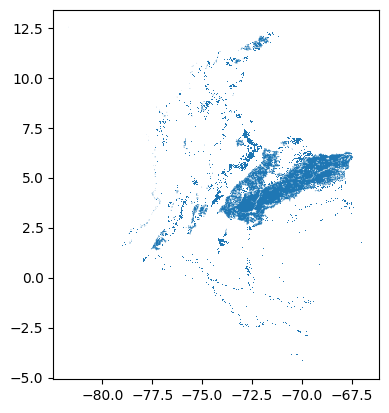

In [ ]:
grassland_roi_gdf = geemap.ee_to_geopandas(grassland_roi)
#ecozones_gdf = eco_zones.filterBounds(colombia_boundary.geometry())
ecozone_in_grassland_gdf = gpd.clip(eco_shp, grassland_roi_gdf)

ecozone_in_grassland_gdf.plot()

Export Ecozones in Grassland to GDRIVE

In [ ]:
import shutil
#this first line creates a new folder "grassland_ecozones" with the shape-files
ecozone_in_grassland_gdf.to_file("/tmp/grassland_ecozones", driver="ESRI Shapefile")

#this second line compresses the files from the folder to a .zip file. named: gdf-zipfile.zip.
shutil.make_archive("grasslands_zip", "zip", "/tmp/grassland_ecozones")

'/content/grasslands_zip.zip'

In [ ]:
colombia_ecozones_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67 entries, 8799 to 8014
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NID       67 non-null     int64   
 1   GEZ_TERM  67 non-null     object  
 2   geometry  67 non-null     geometry
 3   coords    67 non-null     object  
dtypes: geometry(1), int64(1), object(2)
memory usage: 2.6+ KB


KeyError: ignored

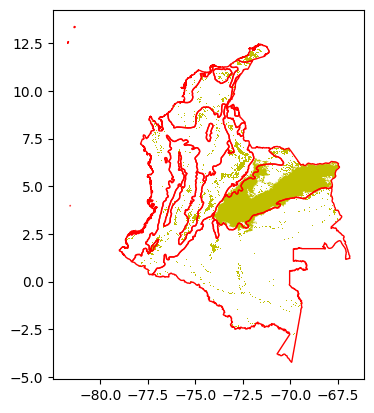

In [ ]:
ax  = grassland_roi_gdf.plot(color ="y")

colombia_ecozones_gdf.plot(ax = ax, color='none', edgecolor='red')
#colombia_ecozones_gdf.insert(0, 'NID', range(1, 1 + len(colombia_ecozones_gdf))) # Only applies once
colombia_ecozones_gdf['coords'] = colombia_ecozones_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
colombia_ecozones_gdf['coords'] = [coords[0] for coords in colombia_ecozones_gdf['coords']]
for idx, row in colombia_ecozones_gdf.iterrows():
    plt.annotate(text=row['NID'], xy=row['coords'], horizontalalignment='center')


clb_df = pd.DataFrame(colombia_ecozones_gdf.drop(columns='geometry'))
clb_df.info()
clb_df[['NID']]

Compute area for each ecozone and add as property
1. reproject the ecozones in grassland to a Cylindrical equal-area format with {'proj':'cea'} that preserve area measure.
2. Compute area in a lambda

In [ ]:
ecozone_reprojected = ecozone_in_grassland_gdf.to_crs('epsg:3857')
print(ecozone_reprojected.crs)
ecozone_reprojected["geometry"].head()

epsg:3857


8799     MULTIPOLYGON (((-8190508.343 478395.939, -8190...
10069    MULTIPOLYGON (((-8308575.210 632814.416, -8307...
9838     MULTIPOLYGON (((-8439946.093 756521.843, -8442...
8625     MULTIPOLYGON (((-8245868.642 1269487.731, -824...
10533    MULTIPOLYGON (((-8608898.275 195002.119, -8608...
Name: geometry, dtype: geometry

<Axes: >

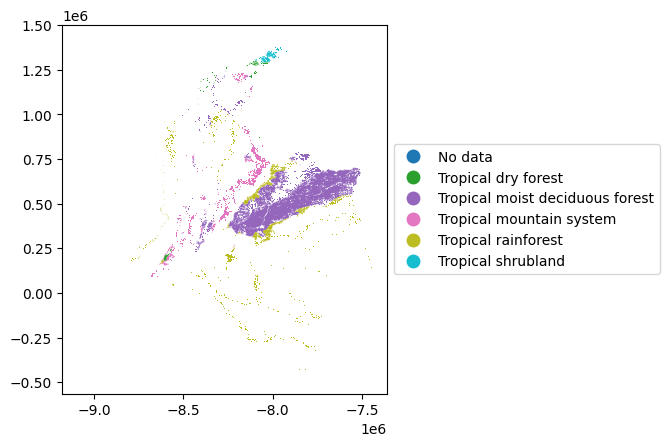

In [ ]:
ecozone_reprojected.plot(
    column="GEZ_TERM",
    categorical=True,
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"}
    )

In [ ]:
ecozone_reprojected["areaHa"] = ecozone_reprojected.area * 0.0001 #area in Hectares
ecozones_with_area_sorted = ecozone_reprojected.sort_values(by=['areaHa'], ascending=False)
ecozones_with_area_sorted.head()

zones_dissolved = ecozones_with_area_sorted.groupby("GEZ_TERM")["areaHa"].sum()

zones_dissolved.info()

<class 'pandas.core.series.Series'>
Index: 6 entries, No data to Tropical shrubland
Series name: areaHa
Non-Null Count  Dtype  
--------------  -----  
6 non-null      float64
dtypes: float64(1)
memory usage: 96.0+ bytes


In [ ]:
for index, row in pd.DataFrame(zones_dissolved).iterrows():
    print(format(row['areaHa'], '.3f'))

190.888
249609.100
11455309.800
2194342.223
3051775.798
291451.931


Export the Ecozones with area as CSV (the fole is automaticaly downloaded)

In [ ]:
from google.colab import files
ecozone_reprojected.to_csv('output.csv', encoding = 'utf-8-sig')
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Export to G Drive location

In [ ]:
# Export the FeatureCollection to a KML file.
task = ee.batch.Export.table.toDrive(**{
  'collection': ecozone_reprojected,
  'description':'ecozone_with_area_added',
  'fileFormat': 'CSV'
})
task.start()

IPCC Tier 1 total carbon stock values for each ecofloristic zone as the minimum potential carbon stock values for 0% tree cover






In [ ]:
cstock_values = pd.read_csv('drive/My Drive/Colab Notebooks/carbon_analysis/ipcc_tier_1_carbon_stocks.csv')
print(cstock_values)


                          Eco_zone  minimum  maximum  root_shoot_ratio  \
0              Tropical dry forest      0.6        4               126   
1  Tropical Moist deciduous forest     77.0        8               128   
2         Tropical mountain system      8.8        6                87   
3              Tropical rainforest     12.0        8               193   
4               Tropical shrubland      1.7        4               126   

   Unnamed: 4  
0        0.28  
1        0.24  
2        0.27  
3        0.37  
4        0.28  


Join Ecozones with Areas   DGF with the c stocks values

In [ ]:
ecozones_joined_with_cstocks = pd.merge(zones_dissolved,cstock_values, left_on='GEZ_TERM', right_on='Eco_zone')
print(ecozones_joined_with_cstocks)

         areaHa                  Eco_zone  minimum  maximum  root_shoot_ratio  \
0  2.496091e+05       Tropical dry forest      0.6        4               126   
1  2.194342e+06  Tropical mountain system      8.8        6                87   
2  3.051776e+06       Tropical rainforest     12.0        8               193   
3  2.914519e+05        Tropical shrubland      1.7        4               126   

   Unnamed: 4  
0        0.28  
1        0.27  
2        0.37  
3        0.28  


Determine tree cover percent for the grassland regions of intrests through the year 2000, 2008 and 2017

In [ ]:

MODIS_TREE_COVER_PERCENT = ee.ImageCollection('MODIS/006/MOD44B')

mod44b2000 = MODIS_TREE_COVER_PERCENT.filterDate('2000-01-01', '2000-12-30').first().select(['Percent_Tree_Cover']);#.clipToCollection(colombia_boundary);
mod44b2008 = MODIS_TREE_COVER_PERCENT.filterDate('2008-01-01', '2008-12-30').first().select(['Percent_Tree_Cover'])#.clipToCollection(colombia_boundary)
mod44b2017 = MODIS_TREE_COVER_PERCENT.filterDate('2017-01-01', '2017-12-30').first().select(['Percent_Tree_Cover'])#.clipToCollection(colombia_boundary);



Compute the Tree Cover change and plot with

In [ ]:
# Import the Image function from the IPython.display module.
from IPython.display import Image

In [ ]:

tree_Cover_change2000_2008 = mod44b2000.subtract(mod44b2008)
print(tree_Cover_change2000_2008.getInfo())
bounds = tree_Cover_change2000_2008.bounds()
tree_Cover_change2000_2008 = tree_Cover_change2000_2008.clipToBounds(bounds)
# Display a thumbnail of global elevation.
Image(url = tree_Cover_change2000_2008
  .getThumbUrl({'min': -100, 'max': 100, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))


{'type': 'Image', 'bands': [{'id': 'Percent_Tree_Cover', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -255, 'max': 255}, 'crs': 'SR-ORG:6974', 'crs_transform': [231.656358264, 0, -20015109.354, 0, -231.656358264, 10007554.677]}]}


AttributeError: ignored